# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
bs = 64
bptt = 70

In [4]:
PATH=Path('data/wikitext-2-raw')
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [5]:
# epoch = 1
# lr = 1e-3
momentum = (0.8,0.7)
weight_decay = 1.2e-6

In [6]:
vocab = data.train_ds.vocab
vocab_sz = len(vocab.itos); vocab_sz

29836

In [7]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos = xxmaj valkyria xxmaj chronicles xxup iii =',
 array([   2,   16,    4, 3813,    4, 3877,    5,  884,   16]))

In [8]:
# data.show_batch()

In [9]:
class LMTrainer(LearnerCallback):
    def __init__(self, learn):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        position_ids = torch.arange(last_input.shape[-1], dtype=torch.long, device=last_input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(last_input)
        target_ids = torch.arange(last_target.shape[-1], dtype=torch.long, device=last_target.device)
        target_ids = target_ids.unsqueeze(0).expand_as(last_target)
        return (last_input, position_ids, last_target, target_ids), last_target[:, 1:]

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [10]:
import transformer.Constants as Constants
# from dataset import TranslationDataset, paired_collate_fn
from transformer.Models import Transformer
from transformer.Optim import ScheduledOptim

In [11]:
transformer = Transformer(
    n_src_vocab=vocab_sz,
    n_tgt_vocab=vocab_sz,
    len_max_seq=data.bptt+data.max_len,
#     len_max_seq=opt.max_token_seq_len,
    tgt_emb_prj_weight_sharing=True,
    emb_src_tgt_weight_sharing=True,
#     d_k=opt.d_k,
#     d_v=opt.d_v,
#     d_model=opt.d_model,
#     d_word_vec=opt.d_word_vec,
#     d_inner=opt.d_inner_hid,
#     n_layers=opt.n_layers,
#     n_head=opt.n_head,
#     dropout=opt.dropout
)

### Create Language learner

In [12]:
learn = LanguageLearner(data, transformer, bptt=bptt, clip=0.1)

In [13]:
learn.callbacks = [LMTrainer(learn)]

In [14]:
learn.opt_func = torch.optim.SGD

In [15]:
# learn = learn.to_fp16(loss_scale=256)

In [16]:
# learn.lr_find()

In [17]:
# learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1, 1e-5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

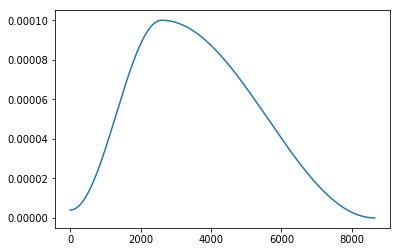

In [15]:
learn.recorder.plot_lr()

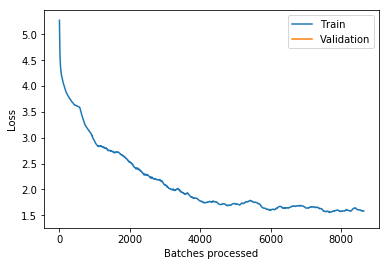

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('transformer_run1_1en4');

In [ ]:
# 5e-4 starts to diverge at 30% - 1800 it / 8600

In [ ]:
# 1:35 per epoch